In [5]:
from torch.utils.data import DataLoader
import dataset
import utils

import dataclasses
from collections.abc import Sequence, Mapping

@dataclasses.dataclass
class DepParseDataPickle:
    input_strs: Sequence[str]
    dev_data: Sequence[Mapping[str, str]]

In [28]:
from transformers import AutoConfig
from einops import rearrange
import cache_hidden_states
import torch
import utils
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity


for model_name in ['google/gemma-2b']:
    model = utils.get_model(model_name)
    tokenizer = utils.get_tokenizer(model_name)
    hidden_size = model.config.hidden_size
    num_layers = model.config.num_hidden_layers

    root_hidden_state = utils.get_word_hidden_states(
            ["ROOT"], tokenizer, model
        )[0]
    root_hidden_state = torch.cat(root_hidden_state, dim=0).unsqueeze(1)
    assert root_hidden_state.shape == (num_layers, 1, hidden_size)

    data_loader = DataLoader(
        dataset.HeadWordDataset(
                split_name="test",
                model_name=model_name,
                num_layers=num_layers,
                hidden_size=hidden_size,
            ),
    )

    flattened_labels = []
    flattened_preds = [[] for _ in range(num_layers)]
        
    for batch in data_loader:
        hidden_states, labels = batch
        hidden_states = rearrange(hidden_states, "1 w l h -> l w h")
        hidden_states = torch.cat((root_hidden_state, hidden_states), dim=1).cuda()
        labels = torch.tensor([0] + labels)
        flattened_labels.extend(labels.tolist())
        for i in range(num_layers):
            layer_hiddeen_states = hidden_states[i]
            distances = -torch.cdist(layer_hiddeen_states, layer_hiddeen_states, p=2)
            mask = F.pad(torch.eye(distances.shape[0] - 1), (1, 0, 1, 0)).bool()
            distances[mask] = float("-inf")
            preds = distances.softmax(dim=-1).argmax(dim=-1)
            flattened_preds[i].extend(preds.tolist())
                    
    accuracies = [accuracy_score(flattened_labels, preds) for preds in flattened_preds]

    x = list(range(num_layers))
    y = accuracies

    import matplotlib.pyplot as plt

    plt.scatter(x, y)
    plt.xlabel('Layer')
    plt.ylabel('UAS')
    plt.title(model_name)

    plt.savefig(f"unsupervised_plots/{model_name.replace('/', '_')}.png")
    plt.show()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

AssertionError: 

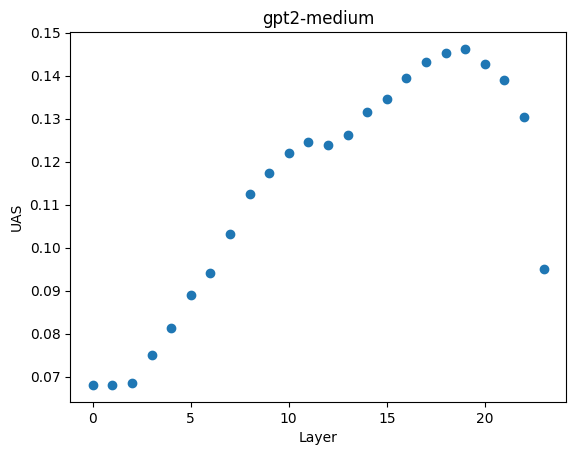